# GEOL0069 Project, Cloud/Snow/Ice classification using a XGBooster and XAI

# 📥 Data Retrieval
We want to retrieve high res. ~10-20m spectral data from alpine geography, in this case the Himalayas, with a strong presence of cloud, snow, and ice cover in order to devise a challenging classification task.

Initially we can query via Google Earth Engine's cloud filtration to identify a Sentinel-2 image to retrieve via the Copernicus Data Node.

All necessary libraries for data handling, visualization, and machine learning, will be imported throughout.


In [ ]:
!pip install earthengine-api

In [ ]:
!earthengine authenticate

E0000 00:00:1748910078.860569     519 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748910078.870896     519 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0603 00:21:24.045176 136307175047168 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20h

In [ ]:
import ee
ee.Initialize()

In [ ]:
# Smaller AOI centered within T45RWM tile (Himalayas / Everest)
aoi = ee.Geometry.Rectangle([84.5, 27.5, 86.5, 28.5])

# Filtering the image based on cloud / snow cover and attempting to
# set a 'No Data' threshold

def has_sufficient_snow(image):
    scl = image.select('SCL')

    # Classes
    snow = scl.eq(11)
    cloud = scl.eq(8).Or(scl.eq(9)).Or(scl.eq(10))
    snow_cloud = snow.Or(cloud)
    no_data = scl.eq(0)

    snow_cloud_fraction = snow_cloud.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=20,
        maxPixels=1e9
    ).get('SCL')

    no_data_fraction = no_data.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=20,
        maxPixels=1e9
    ).get('SCL')

    return image.set({
        'snow_cloud_fraction': snow_cloud_fraction,
        'no_data_fraction': no_data_fraction
    })

sentinel2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(aoi)
    .filterDate('2023-02-01', '2023-05-01')
    .filter(ee.Filter.gte('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 30))
    .sort('CLOUDY_PIXEL_PERCENTAGE')
)

# This drops nulls BEFORE toList()
filtered = (
    sentinel2.map(has_sufficient_snow)
    .filter(ee.Filter.notNull(['snow_cloud_fraction', 'no_data_fraction']))
    .filter(ee.Filter.gte('snow_cloud_fraction', 0.3))  # adjust as needed
    .filter(ee.Filter.eq('no_data_fraction', 0))
    .sort('snow_cloud_fraction', False)
)

image_list = filtered.toList(20)


for i in range(image_list.size().getInfo()):
    img = ee.Image(image_list.get(i))
    date = img.date().format('YYYY-MM-dd').getInfo()
    cloud = img.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
    snow = img.get('snow_cloud_fraction').getInfo()

    tile = img.get('system:index').getInfo()
    spacecraft = img.get('SPACECRAFT_NAME').getInfo()

    print(f"{i}: {date} — Cloud: {cloud}% — Snow: {round(snow*100,1)}% — ID: {tile} — Satellite: {spacecraft}")

0: 2023-03-18 — Cloud: 24.4691% — Snow: 71.6% — ID: 20230318T044701_20230318T045910_T45RVM — Satellite: Sentinel-2A
1: 2023-02-26 — Cloud: 24.142857% — Snow: 65.0% — ID: 20230226T044741_20230226T045120_T45RUM — Satellite: Sentinel-2A
2: 2023-04-25 — Cloud: 27.820855% — Snow: 51.2% — ID: 20230425T045659_20230425T050910_T45RTM — Satellite: Sentinel-2B
3: 2023-03-13 — Cloud: 24.551275% — Snow: 45.7% — ID: 20230313T044709_20230313T045258_T45RVL — Satellite: Sentinel-2B
4: 2023-03-11 — Cloud: 29.176527% — Snow: 38.4% — ID: 20230311T045651_20230311T051035_T45RTM — Satellite: Sentinel-2A
5: 2023-04-02 — Cloud: 23.973076% — Snow: 30.7% — ID: 20230402T044709_20230402T045112_T45RUL — Satellite: Sentinel-2B


1: 2023-02-26 — Cloud: 24.142857% — Snow: 65.0% — ID: 20230226T044741_20230226T045120_T45RUM — Satellite: Sentinel-2A






In [ ]:
import requests
from datetime import datetime, timedelta

# Copernicus credentials
username = "leoncaborek@gmail.com"
password = "MyC0keZer009!"

# Target image information
target_date = "2023-02-26"
tile_id = "T45RUM"

# Step 1: Authenticate and get token
def get_access_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    r = requests.post(url, data=data)
    r.raise_for_status()
    return r.json()["access_token"]

# Step 2: Search for Sentinel-2 products by tile and date
def search_products_by_tile_and_date(tile, date, token):
    base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
    start = f"{date}T00:00:00.000Z"
    end = f"{date}T23:59:59.999Z"
    filter_query = (
        f"$filter=contains(Name,'{tile}') and ContentDate/Start ge {start} and ContentDate/Start le {end} "
        f"and Collection/Name eq 'SENTINEL-2'"
    )
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(f"{base_url}?{filter_query}", headers=headers)
    response.raise_for_status()
    return response.json().get("value", [])

# Step 3: Run the query
token = get_access_token(username, password)
results = search_products_by_tile_and_date(tile_id, target_date, token)

# Step 4: Show the matching product names
if results:
    for i, product in enumerate(results):
        print(f"{i}: {product['Name']} — ID: {product['Id']}")
else:
    print("No products found for that tile and date.")


0: S2A_MSIL1C_20230226T044741_N0509_R076_T45RUM_20230226T063622.SAFE — ID: b5cf4c2d-f98c-4a39-b954-90f6ff223db8
1: S2A_MSIL2A_20230226T044741_N0509_R076_T45RUM_20230226T100703.SAFE — ID: b540c0af-02d7-4007-934d-89c27c9c6514
2: S2A_MSIL2A_20230226T044741_N0510_R076_T45RUM_20240818T161505.SAFE — ID: 703af5af-e134-4286-8814-b15d69f30ca1
3: S2A_MSIL1C_20230226T044741_N0510_R076_T45RUM_20240818T100408.SAFE — ID: e7ff3462-f740-4e44-9851-db32585cf159


We isolate Index 1, Level-2A, as it has surface reflectance and SCL which is post-processed and atmosphere corrected (2023-02-26).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define Copernicus access token (already retrieved earlier)
access_token = token  # assuming you have 'token' from earlier auth

# Define parameters
product_id = "b540c0af-02d7-4007-934d-89c27c9c6514"
file_name = "S2A_MSIL2A_20230226T044741_N0509_R076_T45RUM_20230226T100703"
download_dir = "/content/drive/MyDrive/GEOL0069_Project/Sentinel2_Himalayas"

def download_single_product(product_id, file_name, access_token, download_dir="/content"):
    os.makedirs(download_dir, exist_ok=True)
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {access_token}"}
    r = requests.get(url, headers=headers, stream=True)

    if r.status_code == 200:
        file_path = os.path.join(download_dir, file_name + ".zip")
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded to: {file_path}")
    else:
        print(f"Download failed — {r.status_code}: {r.text}")

# Start download
download_single_product(product_id, file_name, access_token, download_dir)


Downloaded to: /content/drive/MyDrive/GEOL0069_Project/Sentinel2_Himalayas/S2A_MSIL2A_20230226T044741_N0509_R076_T45RUM_20230226T100703.zip


# 🛰️ Load and Preprocess Sentinel-2 Imagery

Load the spectral bands and Scene Classification Layer (SCL) from the Sentinel-2 `.SAFE` archive. Upscale 20m bands to 10m to create a consistent spatial resolution across all features.



In [3]:
!pip install rasterio

In [1]:
import os
from glob import glob
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import zipfile


In [ ]:

zip_path = "/content/drive/MyDrive/GEOL0069_Project/Sentinel2_Himalayas/S2A_MSIL2A_20230226T044741_N0509_R076_T45RUM_20230226T100703.zip"

extract_dir = "/content/drive/MyDrive/GEOL0069_Project/Sentinel2_Himalayas"

# Unzip if not already unzipped
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")



Extraction complete.


In [2]:

# Path to the .SAFE directory
safe_dir = "/content/drive/MyDrive/GEOL0069_Project/Sentinel2_Himalayas/S2A_MSIL2A_20230226T044741_N0509_R076_T45RUM_20230226T100703.SAFE"

# Locate GRANULE folder
granule_dir = glob(os.path.join(safe_dir, "GRANULE", "*"))[0]

# Locate image folders
img_data_10m = os.path.join(granule_dir, "IMG_DATA", "R10m")
img_data_20m = os.path.join(granule_dir, "IMG_DATA", "R20m")

# Define bands of interest
bands_10m = ["B02", "B03", "B04", "B08"]
bands_20m = ["B11", "B12"]
band_paths = {}

# Collect 10m bands
for b in bands_10m:
    pattern = os.path.join(img_data_10m, f"*_{b}_10m.jp2")
    band_paths[b] = glob(pattern)[0]

# Collect 20m bands
for b in bands_20m:
    pattern = os.path.join(img_data_20m, f"*_{b}_20m.jp2")
    band_paths[b] = glob(pattern)[0]

# SCL path
scl_path = glob(os.path.join(img_data_20m, "*_SCL_20m.jp2"))[0]

# 👁️ Visually inspecting spectral bands / SCL

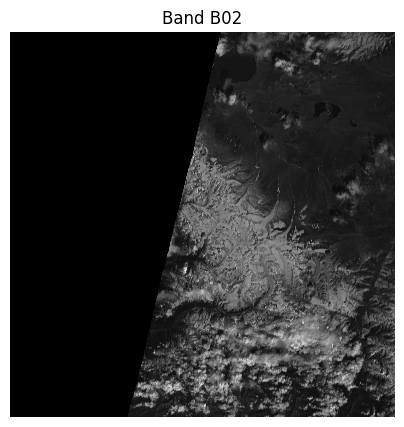

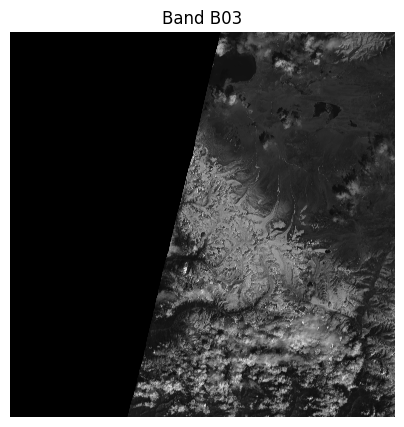

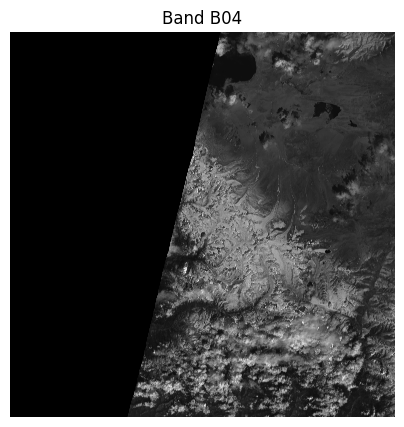

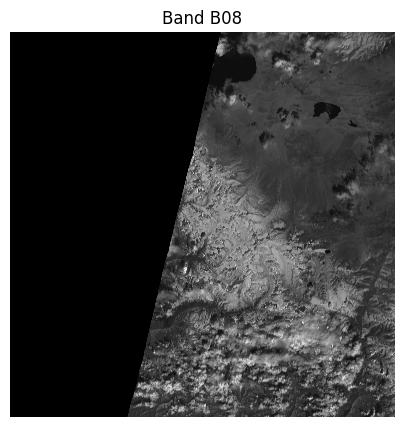

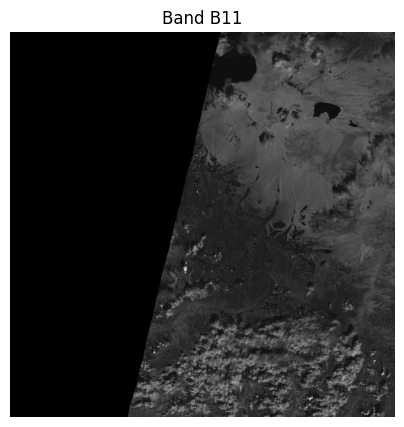

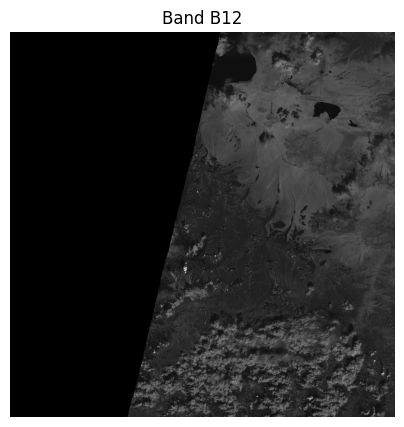

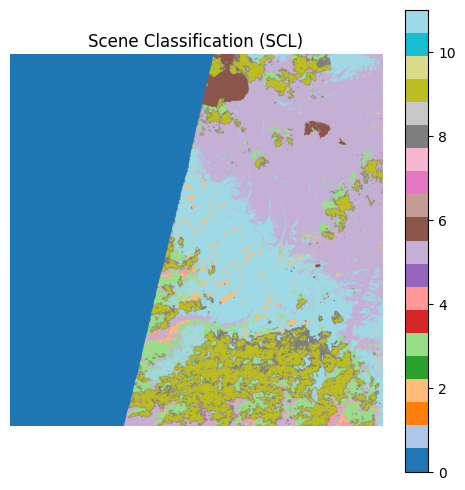

In [4]:
# Plot each band
for b, path in band_paths.items():
    with rasterio.open(path) as src:
        img = src.read(1)
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f"Band {b}")
        plt.axis('off')
        plt.show()

# Plot SCL
with rasterio.open(scl_path) as src:
    scl = src.read(1)

plt.figure(figsize=(6, 6))
plt.imshow(scl, cmap='tab20')
plt.title("Scene Classification (SCL)")
plt.colorbar()
plt.axis('off')
plt.show()

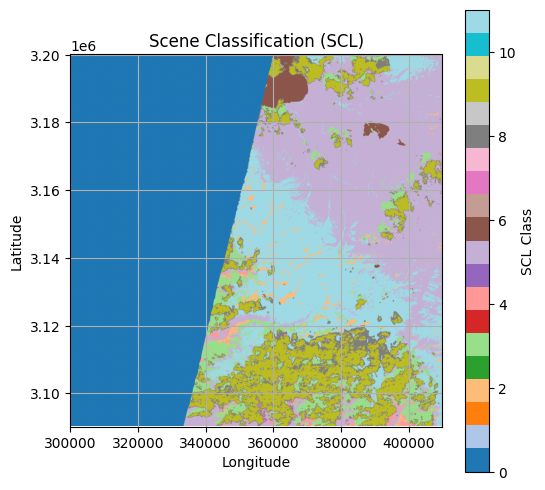

In [5]:
with rasterio.open(scl_path) as src:
    scl = src.read(1)
    bounds = src.bounds

plt.figure(figsize=(6, 6))
plt.imshow(scl, cmap='tab20', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.title("Scene Classification (SCL)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="SCL Class")
plt.grid(True)
plt.show()

In [5]:
# Sentinel-2 Scene Classification Layer (SCL) class mapping
scl_classes = {
    0: "No data",
    1: "Saturated/Defective",
    2: "Dark features",
    3: "Cloud shadow",
    4: "Vegetation",
    5: "Bare soil",
    6: "Water",
    7: "Clouds (low prob)",
    8: "Clouds (medium prob)",
    9: "Clouds (high prob)",
    10: "Thin cirrus",
    11: "Snow/Ice"
}

# Read SCL data
with rasterio.open(scl_path) as src:
    scl = src.read(1)

# Get unique values and map to names
unique_classes = np.unique(scl)
print("SCL classes present in this image:\n")
for val in unique_classes:
    class_name = scl_classes.get(val, "Unknown")
    print(f"{val}: {class_name}")


SCL classes present in this image:

0: No data
2: Dark features
3: Cloud shadow
4: Vegetation
5: Bare soil
6: Water
7: Clouds (low prob)
8: Clouds (medium prob)
9: Clouds (high prob)
10: Thin cirrus
11: Snow/Ice


In [3]:

# Function to manually upscale 20m bands to 10m using nearest-neighbor
def upscale_20m_to_10m(band_20m):
    return np.repeat(np.repeat(band_20m, 2, axis=0), 2, axis=1)

# Bands at 10m resolution
bands_10m = ["B02", "B03", "B04", "B08"]
# Bands at 20m that need upscaling
bands_20m = ["B11", "B12"]

all_bands = {}

# Load 10m bands
for b in bands_10m:
    with rasterio.open(band_paths[b]) as src:
        all_bands[b] = src.read(1)

# Load and upscale 20m bands
for b in bands_20m:
    with rasterio.open(band_paths[b]) as src:
        band = src.read(1)
        all_bands[b] = upscale_20m_to_10m(band)

# Load and upscale SCL
with rasterio.open(scl_path) as src:
    scl = src.read(1)
    scl_10m = upscale_20m_to_10m(scl)

print("Loaded and upscaled all bands to 10m resolution.")
print("Band shapes:")
for b, arr in all_bands.items():
    print(f"{b}: {arr.shape}")
print(f"SCL: {scl_10m.shape}")

# Optional: Stack all features into (H, W, C)
feature_stack = np.stack([all_bands[b] for b in bands_10m + bands_20m], axis=-1)
print(f"\nFeature stack shape: {feature_stack.shape} (Height, Width, Bands)")


Loaded and upscaled all bands to 10m resolution.
Band shapes:
B02: (10980, 10980)
B03: (10980, 10980)
B04: (10980, 10980)
B08: (10980, 10980)
B11: (10980, 10980)
B12: (10980, 10980)
SCL: (10980, 10980)

Feature stack shape: (10980, 10980, 6) (Height, Width, Bands)


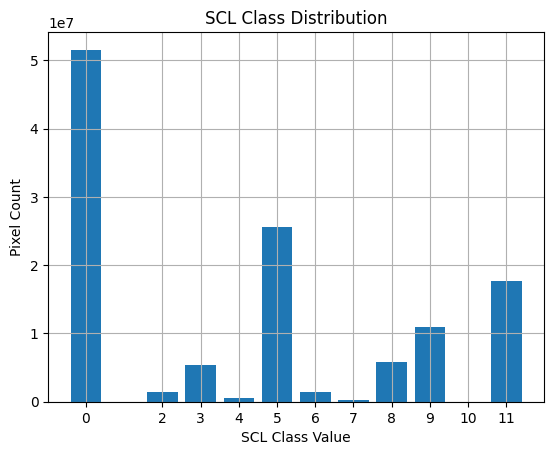

In [7]:

unique, counts = np.unique(scl_10m, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("SCL Class Value")
plt.ylabel("Pixel Count")
plt.title("SCL Class Distribution")
plt.grid(True)
plt.show()


# 📐 Subset and Split the AOI

Split the Area of Interest (AOI) into two spatially distinct regions: one for training and one for spatial generalization (rollout). This avoids spatial leakage during evaluation.

Filter out all pixels marked as "No Data" (SCL = 0) and retain only valid observations for further processing.



In [4]:
# Flatten feature stack and SCL
H, W, C = feature_stack.shape
X = feature_stack.reshape(-1, C)
scl_flat = scl_10m.flatten()

# Mask: keep only valid pixels (SCL ≠ 0)
valid_mask = scl_flat != 0
X_valid = X[valid_mask]
scl_valid = scl_flat[valid_mask]

print(f"X_valid shape: {X_valid.shape}")
print(f"SCL valid unique values: {np.unique(scl_valid)}")


X_valid shape: (69013956, 6)
SCL valid unique values: [ 2  3  4  5  6  7  8  9 10 11]


In [6]:
# Dimensions
H, W = scl_10m.shape
split_row = H // 2  # Horizontal split

# Split SCL
scl_top = scl_10m[:split_row, :]
scl_bottom = scl_10m[split_row:, :]

# Mask out no-data (SCL == 0)
scl_masked_top = np.where(scl_top == 0, np.nan, scl_top)
scl_masked_bottom = np.where(scl_bottom == 0, np.nan, scl_bottom)


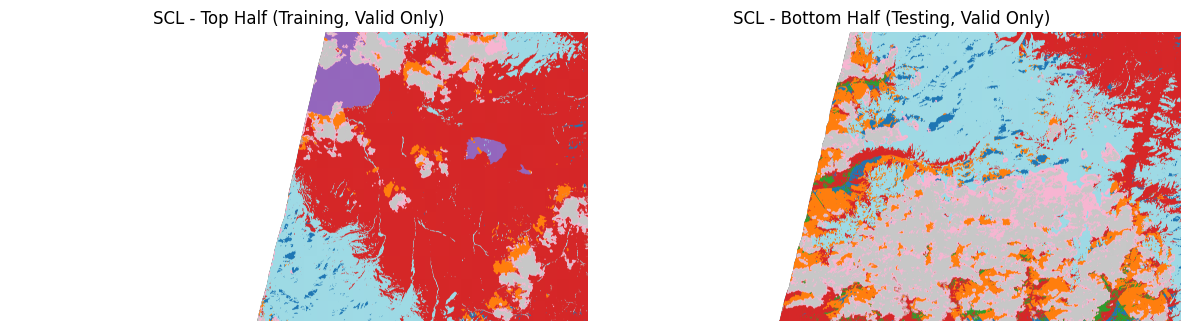

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(scl_masked_top, cmap='tab20')
plt.title("SCL - Top Half (Training, Valid Only)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(scl_masked_bottom, cmap='tab20')
plt.title("SCL - Bottom Half (Testing, Valid Only)")
plt.axis('off')

plt.tight_layout()
plt.show()

# 🏷️ Create Binary Labels (Snow vs. Cloud)

Map the SCL classes to a binary classification task:
- Snow = 1 (SCL = 11)
- Cloud = 0 (SCL = 8–10)
This simplifies the problem to a two-class snow/cloud distinction.


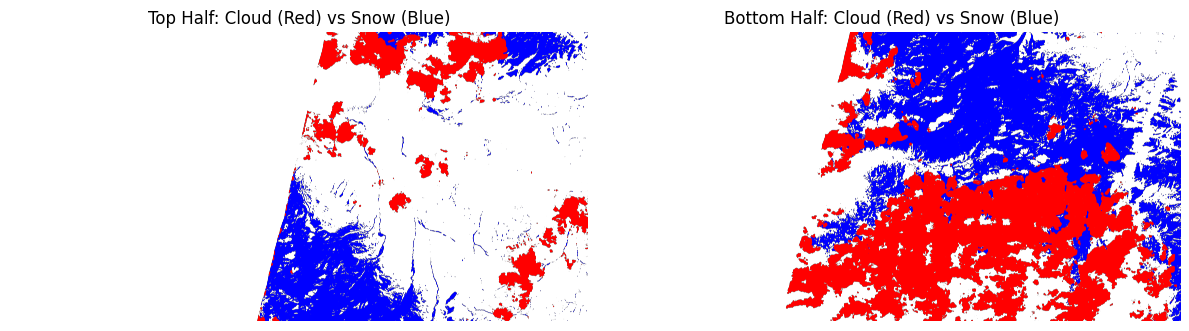

In [7]:
from matplotlib.colors import ListedColormap

cloud_classes = [8, 9, 10]
snow_class = 11

# Force values to integer labels
scl_top_masked = np.where(np.isin(scl_top, cloud_classes), 0,
                  np.where(scl_top == snow_class, 1, np.nan))
scl_bottom_masked = np.where(np.isin(scl_bottom, cloud_classes), 0,
                     np.where(scl_bottom == snow_class, 1, np.nan))

# Define a discrete colormap: [red for cloud, blue for snow]
custom_cmap = ListedColormap(["red", "blue"])

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(scl_top_masked, cmap=custom_cmap, vmin=0, vmax=1)
plt.title("Top Half: Cloud (Red) vs Snow (Blue)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(scl_bottom_masked, cmap=custom_cmap, vmin=0, vmax=1)
plt.title("Bottom Half: Cloud (Red) vs Snow (Blue)")
plt.axis('off')

plt.tight_layout()
plt.show()


# Area Estimate

In [10]:
# Assume `scl_10m` is your scene classification array (10m resolution)
# We'll count only snow/cloud classes: 8, 9, 10, 11
valid_classes = [8, 9, 10, 11]
total_present = [2,3,4,5,6,7,8,9,10,11]
# Create mask
valid_mask = np.isin(scl_10m, valid_classes)
total_mask = np.isin(scl_10m, total_present)

# Calculate total area
total_area_m2 = np.sum(total_mask)
total_area_km2 = total_area_m2 / 1e6

# Count valid pixels
valid_pixel_count = np.sum(valid_mask)
total_pixel_count = np.sum(total_mask)

# Each pixel is 10m x 10m = 100 m²
valid_area_m2 = valid_pixel_count * 100
valid_area_km2 = valid_area_m2 / 1e6
total_area_m2 = total_pixel_count * 100
total_area_km2 = total_area_m2 / 1e6

print(f"Valid snow/cloud pixel count: {valid_pixel_count}")
print(f"Estimated snow/ice/cloud area: {valid_area_km2:.2f} km²")
print(f"Total area: {total_area_km2:.2f} km²")


Valid snow/cloud pixel count: 34344004
Estimated snow/ice/cloud area: 3434.40 km²
Total area: 6901.40 km²


In [10]:
# Split the image stack and SCL into top and bottom halves
mid_row = feature_stack.shape[0] // 2

features_top = feature_stack[:mid_row]
scl_top = scl_10m[:mid_row]

features_bottom = feature_stack[mid_row:]
scl_bottom = scl_10m[mid_row:]


In [11]:
# Apply valid pixel mask to each half
valid_mask_top = scl_top != 0
features_top_valid = features_top[valid_mask_top]
scl_top_valid = scl_top[valid_mask_top]

valid_mask_bottom = scl_bottom != 0
features_bottom_valid = features_bottom[valid_mask_bottom]
scl_bottom_valid = scl_bottom[valid_mask_bottom]


# 🧠 Train XGBoost Model

Train a gradient-boosted decision tree model (XGBoost) using spectral bands as input features. Evaluate performance using accuracy, F1-score, and confusion matrix.


In [12]:
X_train = features_top_valid.reshape(-1, C)
y_train = (scl_top_valid == 11).astype(int)  # snow vs. cloud

X_test = features_bottom_valid.reshape(-1, C)
y_test = (scl_bottom_valid == 11).astype(int)


In [18]:
print("Class 1 (snow):", np.sum(y_test == 1))
print("Class 0 (cloud):", np.sum(y_test == 0))


Class 1 (snow): 12366012
Class 0 (cloud): 25790956


# Train XGBoost with downsampling

In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Reshape features to 2D arrays
X_full = features_top_valid.reshape(-1, feature_stack.shape[-1])
y_full = (scl_top_valid == 11).astype(int)  # 1 = snow, 0 = cloud

# Separate snow and cloud samples
X_snow = X_full[y_full == 1]
X_cloud = X_full[y_full == 0]

n_snow = len(X_snow)
X_cloud_downsampled = X_cloud[np.random.choice(len(X_cloud), n_snow, replace=False)]

# Combine balanced dataset
X_train = np.vstack([X_snow, X_cloud_downsampled])
y_train = np.array([1] * n_snow + [0] * n_snow)

# Shuffle training set
indices = np.random.permutation(len(y_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Test set remains the same (bottom half)
X_test = features_bottom_valid.reshape(-1, feature_stack.shape[-1])
y_test = (scl_bottom_valid == 11).astype(int)

# Train XGBoost without weighting
xgb_spatial = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_spatial.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_spatial.predict(X_test)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83  25790956
           1       0.63      0.95      0.76  12366012

    accuracy                           0.80  38156968
   macro avg       0.80      0.84      0.80  38156968
weighted avg       0.86      0.80      0.81  38156968

Confusion Matrix:
 [[18875258  6915698]
 [  601423 11764589]]


# Without downsampling

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Reshape features to 2D arrays
X_train = features_top_valid.reshape(-1, feature_stack.shape[-1])
y_train = (scl_top_valid == 11).astype(int)  # 1 = snow, 0 = cloud

X_test = features_bottom_valid.reshape(-1, feature_stack.shape[-1])
y_test = (scl_bottom_valid == 11).astype(int)

# Train XGBoost model
xgb_spatial = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_spatial.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_spatial.predict(X_test)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:12:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92  25790956
           1       0.82      0.87      0.85  12366012

    accuracy                           0.90  38156968
   macro avg       0.88      0.89      0.88  38156968
weighted avg       0.90      0.90      0.90  38156968

Confusion Matrix:
 [[23432415  2358541]
 [ 1562610 10803402]]


It is curious to see that we get a more balanced model when we refrain from downsampling cloud labels to match snow.

🔎 Without Downsampling (Full, Imbalanced Data)
Class 0 (Cloud) is the majority, so the model sees way more cloud pixels.

It learns to classify clouds very well (precision = 0.94, recall = 0.91).

Snow performance drops slightly, but the model makes fewer mistakes overall because it's optimized to fit the true distribution.

It’s well-calibrated to the real class distribution (clouds dominate in reality).

👉 Pros:

Reflects true class proportions.

Better general accuracy and balanced predictions.

👉 Cons:

Bias toward the majority class.

Less sensitivity to snow, especially for edge cases.

🔄 With Downsampling (Artificially Balanced)
We give the model a balanced training set, so it treats both classes equally important.

This boosts recall for snow (0.95!), because the model is trained to recognize snow just as frequently as clouds.

But the model is miscalibrated — in the test data, clouds are still 2× more common, so it over-predicts snow, hurting cloud precision (0.97 → 0.63).

👉 Pros:

Better snow detection (high recall).

Forces equal treatment of minority class.

👉 Cons:

Overestimates snow.

Degraded precision for majority class.

Lower accuracy overall.

💡 Why the Downsampled Model Predicts More Snow:
Because it was trained on 50/50 snow-cloud, it expects them to occur equally. But in reality, snow is only ~1/3. So it's too optimistic and flags too many pixels as snow → high false positives.

In [24]:
# Save xgb
xgb_spatial.save_model("/content/drive/MyDrive/GEOL0069_Project/xgb_spatial_snow_cloud_model.json")


# 🔎 Explain Model Predictions with SHAP

Use SHAP (SHapley Additive exPlanations) to analyze which spectral bands contribute most to the snow/cloud classification. Visualize the global feature importance.


In [25]:
!pip install shap


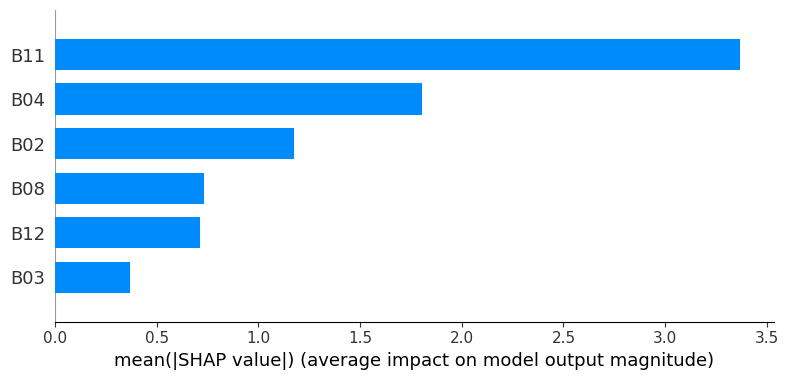


SHAP Summary — Snow Class (label 1)


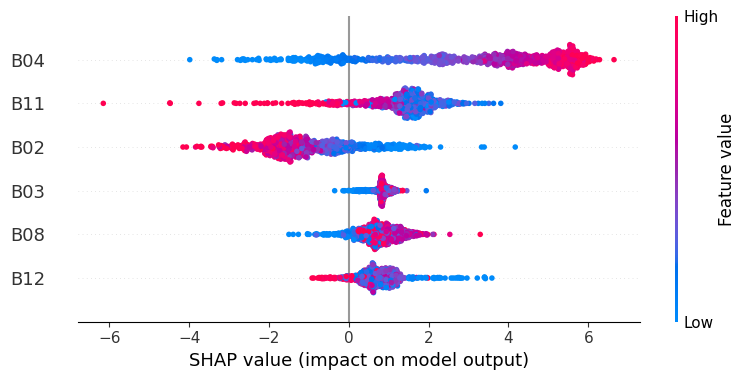


SHAP Summary — Cloud Class (label 0)


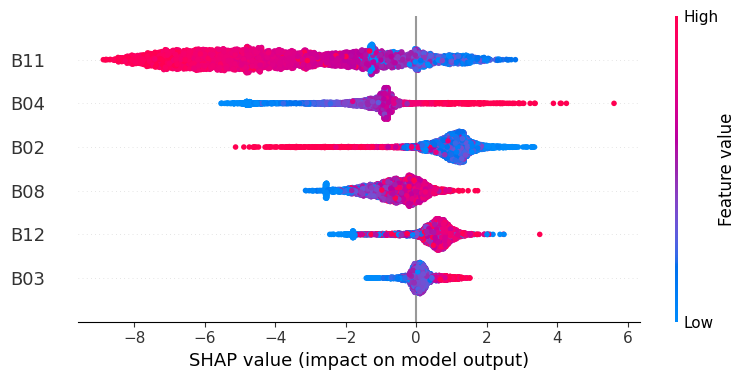

In [26]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define band names and wrap training data in a DataFrame
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
X_df = pd.DataFrame(X_train, columns=band_names)

# Subsample both features and labels together
sample_idx = np.random.RandomState(0).choice(len(X_df), size=5000, replace=False)
X_sample = X_df.iloc[sample_idx]
y_sample = y_train[sample_idx]

# Create SHAP explainer and compute values
explainer = shap.Explainer(xgb_spatial)  # or xgb_top if using top-feature model
shap_values = explainer(X_sample)

# Plot SHAP summary bar plot (overall)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# Class-specific plots
print("\nSHAP Summary — Snow Class (label 1)")
snow_mask = (y_sample == 1)
shap.summary_plot(shap_values[snow_mask], X_sample[snow_mask], plot_type="dot")

print("\nSHAP Summary — Cloud Class (label 0)")
cloud_mask = (y_sample == 0)
shap.summary_plot(shap_values[cloud_mask], X_sample[cloud_mask], plot_type="dot")


🔹 Sentinel-2 Band Definitions
Band	Name	Central Wavelength	Resolution	Description
B02	Blue	490 nm	10 m	Useful for detecting water and atmospheric particles
B04	Red	665 nm	10 m	Sensitive to vegetation, useful for indices like NDVI
B11	SWIR (Shortwave Infrared) 1	1610 nm	20 m	Penetrates atmospheric moisture, highly responsive to snow/ice and clouds

🔍 Why These Bands Matter for Snow vs. Cloud
B02 (Blue)
Snow is highly reflective in visible bands, especially blue.

Clouds also reflect well here, but can vary more in brightness.

So, B02 helps distinguish bright surfaces, but not perfectly on its own.

B04 (Red)
Snow still reflects a lot in red, but less than in blue.

Vegetation strongly absorbs in red — so this helps filter out non-snow, non-cloud pixels.

Paired with B02 or B08, it's also useful in NDVI-like indices.

B11 (SWIR)
This is the most powerful for separating snow and cloud:

Snow has low reflectance in SWIR.

Clouds (especially water clouds) remain relatively bright in SWIR.

This contrast makes B11 extremely useful — it's why it's also key in the NDSI (Normalized Difference Snow Index):

$$
\text{NDSI} = \frac{B03 - B11}{B03 + B11}
$$



🔎 Why B11 Often Comes Out on Top (SHAP/XGBoost)

XGBoost assigns high importance to features that help split the decision boundaries cleanly.

Since B11 clearly separates spectral signatures of snow and cloud, it's often ranked highest.

B02 and B04 help refine that decision when B11 alone isn't conclusive.

# Retrain XGB using top 3 spectral bands (B11, B02, B04):

In [27]:
# Based on SHAP or importance plot
top_features = ["B11", "B02", "B04"]  # Example: top 3 bands
# Map band names to column indices
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
feature_indices = [band_names.index(b) for b in top_features]

# Slice the inputs to top features only
X_train_top = X_train[:, feature_indices]
X_test_top = X_test[:, feature_indices]


In [28]:
xgb_spatial_top = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_spatial_top.fit(X_train_top, y_train)

y_pred_top = xgb_spatial_top.predict(X_test_top)

print("Classification Report (Top Features):\n", classification_report(y_test, y_pred_top))
print("Confusion Matrix (Top Features):\n", confusion_matrix(y_test, y_pred_top))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:25:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Top Features):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93  25790956
           1       0.86      0.85      0.86  12366012

    accuracy                           0.91  38156968
   macro avg       0.89      0.89      0.89  38156968
weighted avg       0.91      0.91      0.91  38156968

Confusion Matrix (Top Features):
 [[24091936  1699020]
 [ 1855035 10510977]]


In [29]:
# Save xgb_top
xgb_spatial_top.save_model("/content/drive/MyDrive/GEOL0069_Project/xgb_spatial_B11+B02+B04_snow_cloud_model.json")


# 🌍 Comparing the all bands vs top feature bands rollout predictions

In [30]:
from sklearn.metrics import accuracy_score, f1_score

# Full model
acc_full = accuracy_score(y_test, y_pred)
f1_full = f1_score(y_test, y_pred)

# Top-feature model
acc_top = accuracy_score(y_test, y_pred_top)
f1_top = f1_score(y_test, y_pred_top)

# Print results
print("Full Model — Accuracy:", round(acc_full, 4), "| F1 Score:", round(f1_full, 4))
print("Top-Feature Model — Accuracy:", round(acc_top, 4), "| F1 Score:", round(f1_top, 4))


Full Model — Accuracy: 0.8972 | F1 Score: 0.8464
Top-Feature Model — Accuracy: 0.9069 | F1 Score: 0.8554


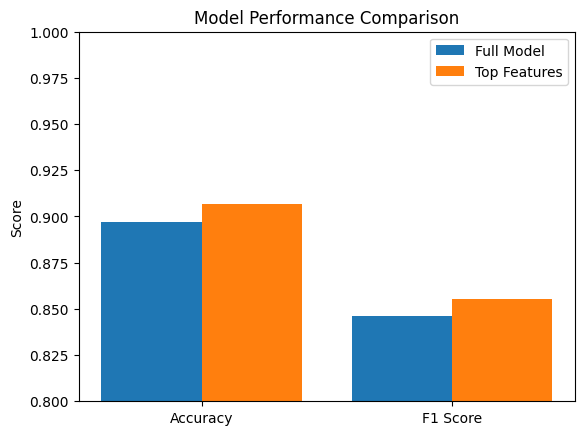

In [31]:
metrics = ['Accuracy', 'F1 Score']
full_scores = [acc_full, f1_full]
top_scores = [acc_top, f1_top]

x = range(len(metrics))
plt.bar(x, full_scores, width=0.4, label='Full Model', align='center')
plt.bar([i + 0.4 for i in x], top_scores, width=0.4, label='Top Features', align='center')

plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


# Concluding remarks

🔍 Interpretation:
Top-Feature Model (B02, B04, B11) slightly outperforms the full model on both accuracy and F1 score.

This suggests:

Some of the other bands might be adding noise, redundant information, or insight that is mainly relevant to the classification outside of snow/ice and cloud.

The selected bands (especially B11) may capture the most discriminative features for distinguishing cloud vs snow.

🤔 Why might this be happening?
B11 (SWIR) is sensitive to snow moisture content and distinguishes snow from clouds and water.

B04 (Red) and B02 (Blue) help identify clouds based on reflectance characteristics.

Removing less informative bands (like NIR or some VNIRs) may be reducing overfitting.